In [31]:
# Data treatment
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignoring warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Importing custom functions and classes
# -----------------------------------------------------------------------
from src.support_eda import plot_categoric_distribution, plot_correlation_matrix, plot_numeric_distribution, plot_relation_tv_numeric, plot_outliers
from src.support_null_handling import MissingValuesHandler

### Importing data

In [32]:
df = pd.read_csv('../data/output/autorenew_eda.csv', index_col=0).reset_index(drop=True)

## Context

We are a company dedicated to finding second-hand vehicles to sell to our customers. Our main clients are individuals or families looking for an affordable vehicle that meets their needs.

To select the vehicles we are willing to sell, we will use various criteria to filter our data and build an effective predictive model.

### Criteria and Filters

`price`: The maximum price our customers are willing to pay is 30,000. To allow a safety margin of 100%, we will set the limit at 60,000 to avoid excluding potentially interesting vehicles within this range while filtering out luxury or excessively expensive vehicles that are unlikely to appeal to our clients.

`yearOfRegistration`: To comply with current environmental regulations, we only sell vehicles registered in the 21st century, meaning the registration year must be 2001 or later.

`powerCV`: In general, vehicles with power exceeding 300 horsepower are considered high-end. We will therefore set the upper limit at 400 horsepower.

`notRepairedDamage`: We want to ensure the vehicles have no unrepaired damage, so we will only include vehicles that meet this condition.

Aplying filters

In [33]:
filter_price = df['price'] <= 60000
filter_year = df['yearOfRegistration'] > 2000
filter_power = df['powerCV'] <= 400
filter_damage = df['notRepairedDamage'] == 'no'

In [34]:
df.groupby('notRepairedDamage')['price'].median().round(2)

notRepairedDamage
no         4000.0
unkonwn    1650.0
yes        1000.0
Name: price, dtype: float64

Before applying the filters, we observe that the median price of vehicles without damage is four times higher than that of damaged vehicles, while those in the "unknown" category are much closer in price to damaged vehicles than to undamaged ones. This does not necessarily mean they are damaged, but it reinforces the decision to include only vehicles we can confirm are in good condition.

In [35]:
filtered_df = df[filter_price & filter_year & filter_power & filter_damage]

print(f"We kept {filtered_df.shape[0]} entries which represent {round(filtered_df.shape[0] / df.shape[0] * 100, 2)}% of the total data")

We kept 172432 entries which represent 48.85% of the total data


Now the column `notRepairedDamage` makes no sense since all values are `'no'`. Let's drop it.

In [36]:
filtered_df.drop(columns='notRepairedDamage', inplace=True)

Let's take a quick view before saving this dataframe

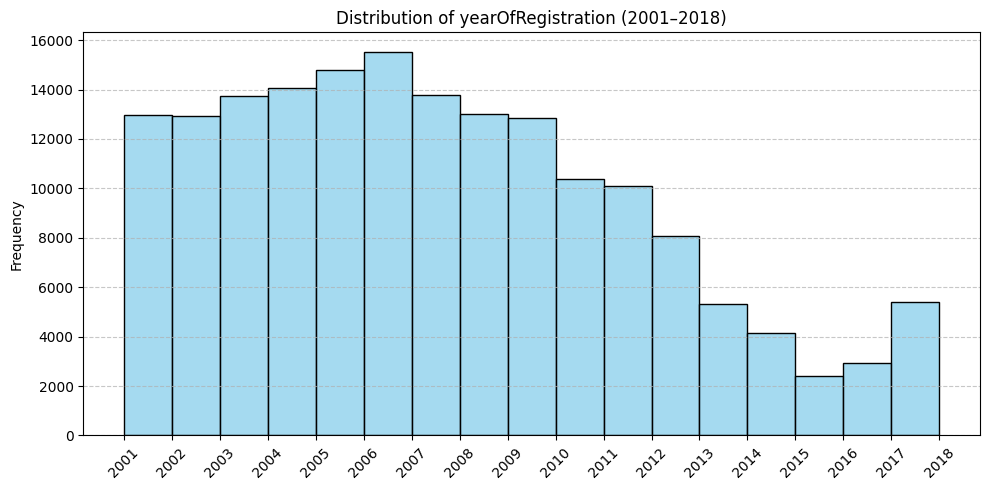

In [37]:
plot_numeric_distribution(filtered_df, 2001, 2018, 'yearOfRegistration', n=1)

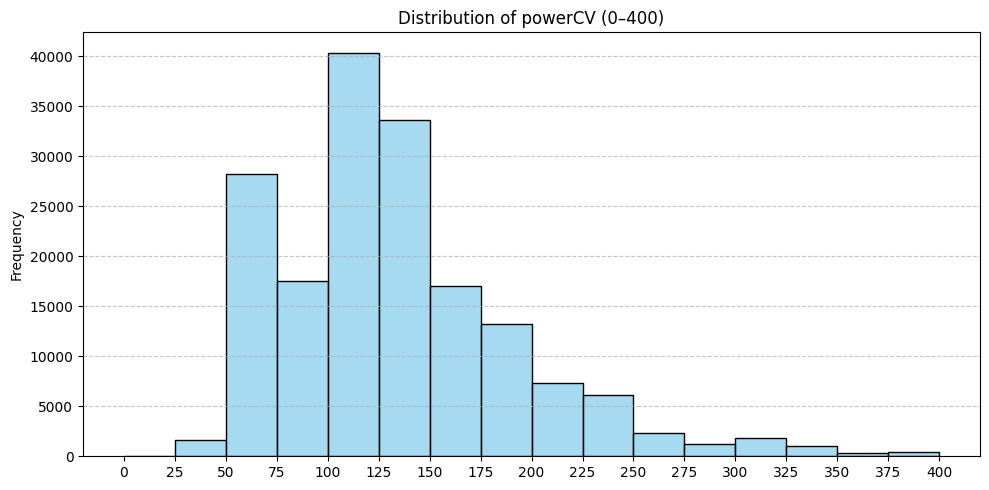

In [38]:
plot_numeric_distribution(filtered_df, 0, 400, 'powerCV', n = 25, rotation=0)

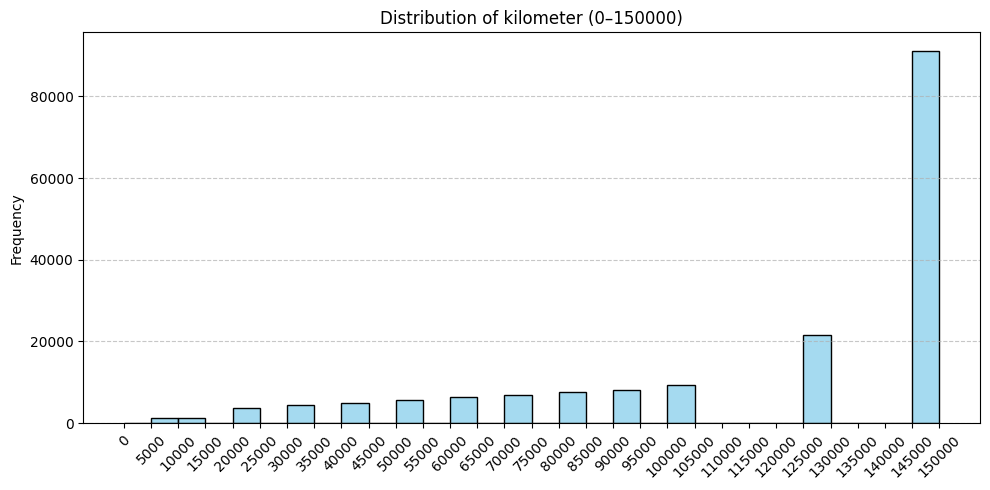

In [39]:
plot_numeric_distribution(filtered_df, 0, 150000, 'kilometer', n = 5000)

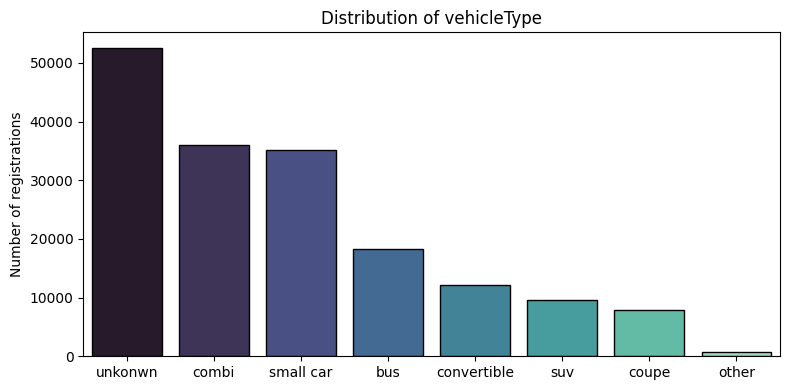

In [40]:
plot_categoric_distribution(filtered_df, 'vehicleType', rotation=0)

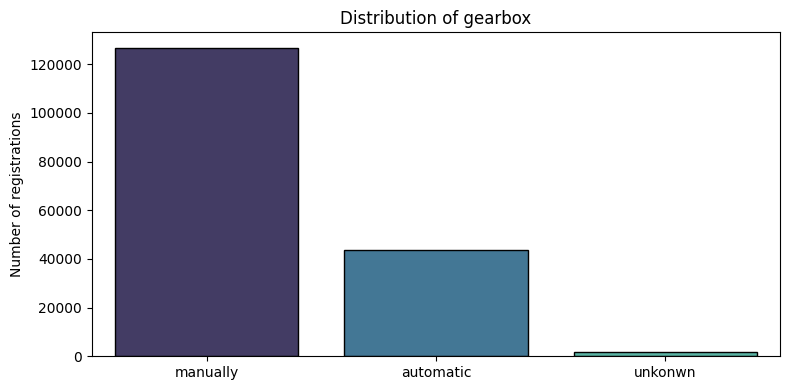

In [41]:
plot_categoric_distribution(filtered_df, 'gearbox', rotation=0)

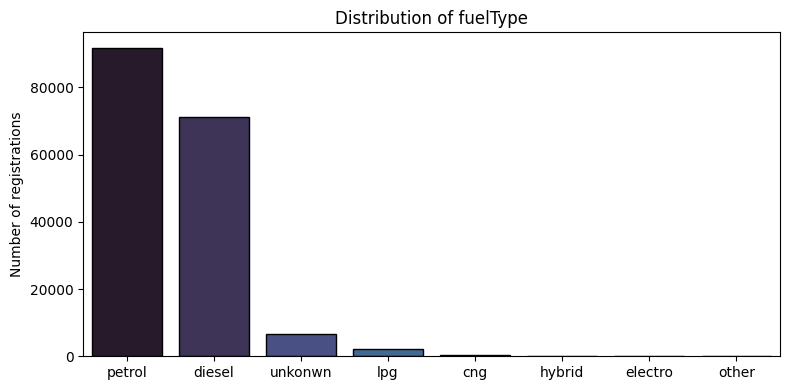

In [42]:
plot_categoric_distribution(filtered_df, 'fuelType', rotation=0)

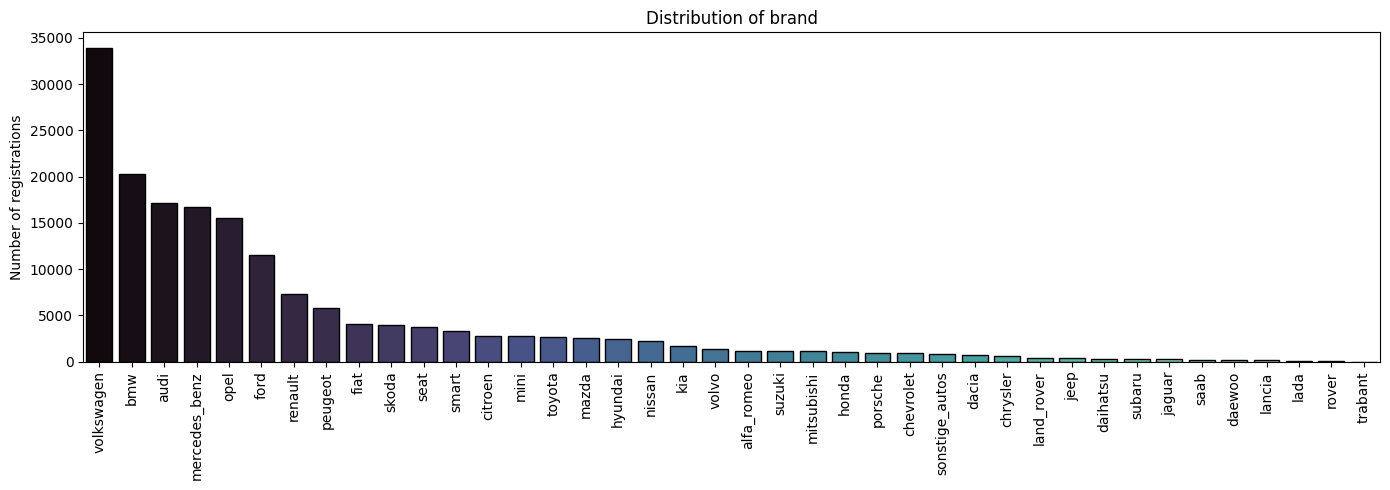

In [43]:
plot_categoric_distribution(filtered_df, 'brand', size=(14, 5), rotation=90)

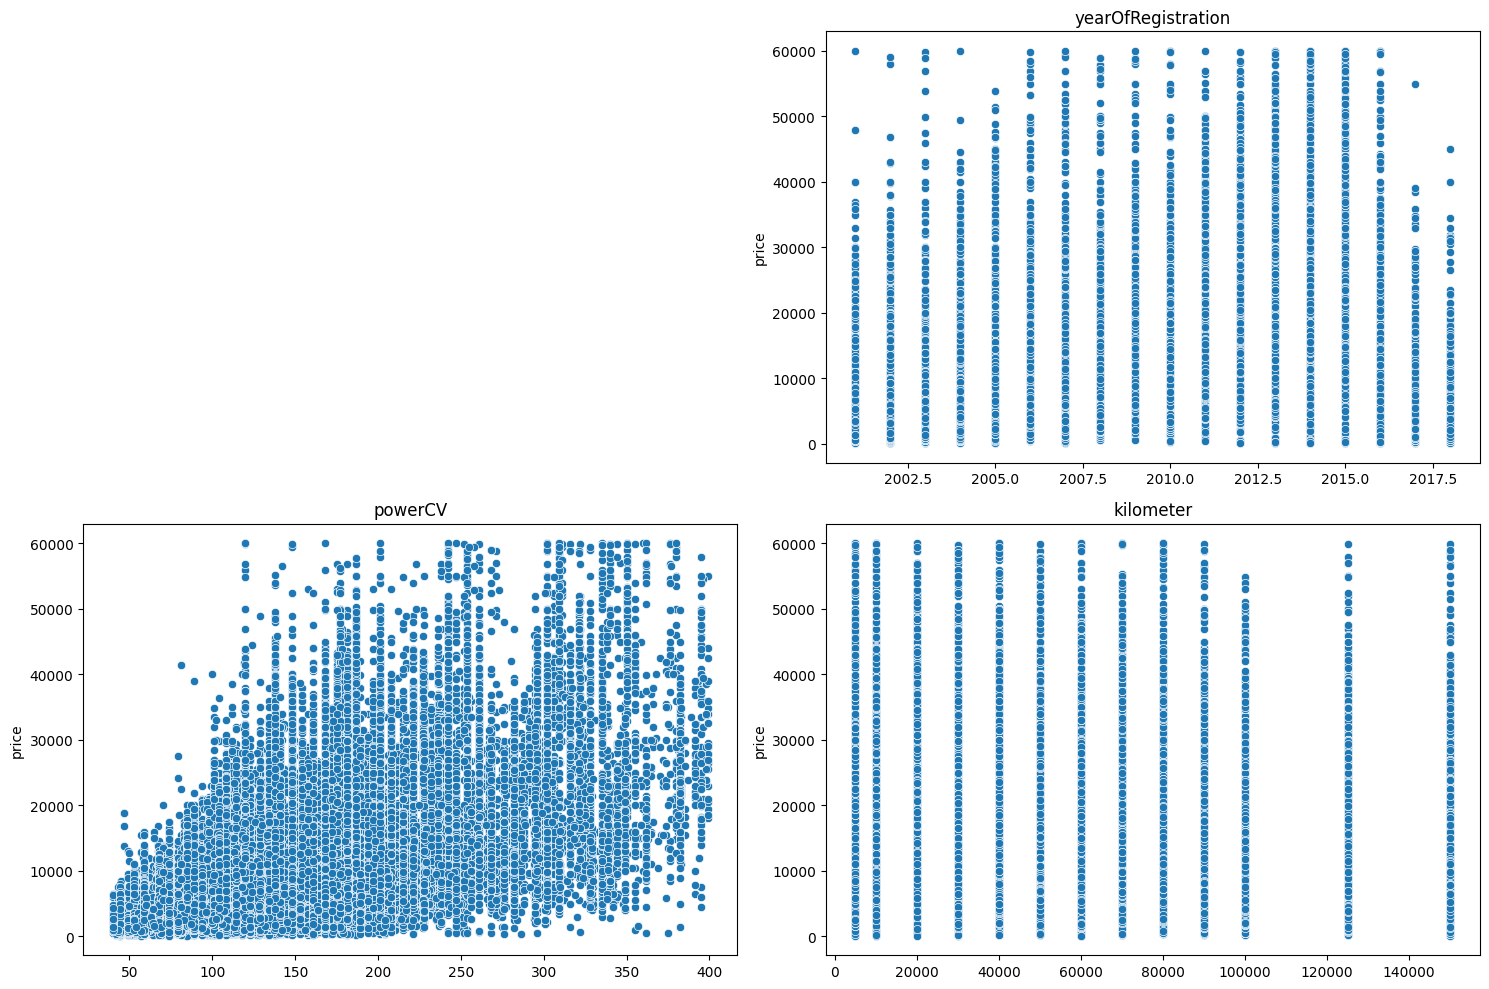

In [44]:
plot_relation_tv_numeric(filtered_df, 'price')

The scatter plots are not very helpful. Let's check the correlation using a heatmap.

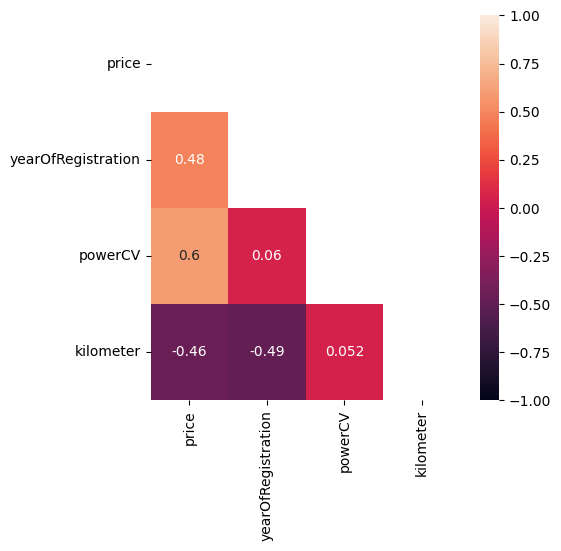

In [45]:
plot_correlation_matrix(filtered_df)

Now the correlations are stronger and more significant, so within the segment of vehicles that interest us, there does seem to be a clearer relationship between the variables previously discussed in the EDA.

We save the dataframe as a CSV file.

In [46]:
filtered_df.to_csv('../data/output/autorenew_segmented.csv')

In [47]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172432 entries, 3 to 352978
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               172432 non-null  int64  
 1   vehicleType         172432 non-null  object 
 2   yearOfRegistration  172432 non-null  float64
 3   gearbox             172432 non-null  object 
 4   powerCV             172432 non-null  float64
 5   kilometer           172432 non-null  int64  
 6   fuelType            172432 non-null  object 
 7   brand               172432 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 11.8+ MB


---

### Missing values handling

By applying the previous filters, we have eliminated any missing values that may have existed before.

In [48]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172432 entries, 3 to 352978
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               172432 non-null  int64  
 1   vehicleType         172432 non-null  object 
 2   yearOfRegistration  172432 non-null  float64
 3   gearbox             172432 non-null  object 
 4   powerCV             172432 non-null  float64
 5   kilometer           172432 non-null  int64  
 6   fuelType            172432 non-null  object 
 7   brand               172432 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 11.8+ MB


However, in the unfiltered data, there were null values that we will handle instead of simply removing them. We will then apply the filters and save another copy of the dataframe with the nulls managed.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352979 entries, 0 to 352978
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               352979 non-null  int64  
 1   vehicleType         352979 non-null  object 
 2   yearOfRegistration  352807 non-null  float64
 3   gearbox             352979 non-null  object 
 4   powerCV             316255 non-null  float64
 5   kilometer           352979 non-null  int64  
 6   fuelType            352979 non-null  object 
 7   brand               352979 non-null  object 
 8   notRepairedDamage   352979 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 24.2+ MB


The nulls in the categorical variables had already been imputed as an "unknown" category, but there are still some null values in the numerical variables. Let’s look at how to handle them.

In [50]:
# We use the MissingValuesHandler custom class

missing_values = MissingValuesHandler(df)
missing_values.get_missing_values_percentages()

yearOfRegistration     0.048728
powerCV               10.404018
dtype: float64

We have very few null values. We will handle them using the KNN algorithm and an iterative imputer (BayesianRidge).

In [51]:
missing_values.use_knn()

,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage,yearOfRegistration_knn,powerCV_knn
0,480,unkonwn,1993.0,manually,NaN,150000,petrol,volkswagen,unkonwn,1993.0,130.6
1,18300,coupe,2011.0,manually,187.0,125000,diesel,audi,yes,2011.0,187.0
2,9800,suv,2004.0,automatic,161.0,125000,diesel,jeep,unkonwn,2004.0,161.0
3,1500,small car,2001.0,manually,74.0,150000,petrol,volkswagen,no,2001.0,74.0
4,3600,small car,2008.0,manually,68.0,90000,diesel,skoda,no,2008.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...
352974,2200,unkonwn,2005.0,unkonwn,NaN,20000,unkonwn,sonstige_autos,unkonwn,2005.0,113.6
352975,1199,convertible,2000.0,automatic,100.0,125000,petrol,smart,no,2000.0,100.0
352976,9200,bus,1996.0,manually,101.0,150000,diesel,volkswagen,no,1996.0,101.0
352977,3400,combi,2002.0,manually,99.0,150000,diesel,volkswagen,unkonwn,2002.0,99.0


In [ ]:
missing_values.use_iterative()

,price,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage,yearOfRegistration_knn,powerCV_knn,yearOfRegistration_iterative,powerCV_iterative
0,480,unkonwn,1993.0,manually,NaN,150000,petrol,volkswagen,unkonwn,1993.0,130.6,1993.0,111.695022
1,18300,coupe,2011.0,manually,187.0,125000,diesel,audi,yes,2011.0,187.0,2011.0,187.000000
2,9800,suv,2004.0,automatic,161.0,125000,diesel,jeep,unkonwn,2004.0,161.0,2004.0,161.000000
3,1500,small car,2001.0,manually,74.0,150000,petrol,volkswagen,no,2001.0,74.0,2001.0,74.000000
4,3600,small car,2008.0,manually,68.0,90000,diesel,skoda,no,2008.0,68.0,2008.0,68.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
352974,2200,unkonwn,2005.0,unkonwn,NaN,20000,unkonwn,sonstige_autos,unkonwn,2005.0,113.6,2005.0,126.783000
352975,1199,convertible,2000.0,automatic,100.0,125000,petrol,smart,no,2000.0,100.0,2000.0,100.000000
352976,9200,bus,1996.0,manually,101.0,150000,diesel,volkswagen,no,1996.0,101.0,1996.0,101.000000
352977,3400,combi,2002.0,manually,99.0,150000,diesel,volkswagen,unkonwn,2002.0,99.0,2002.0,99.000000


In [59]:
missing_values.method_comparison().round(2).T

,count,mean,std,min,25%,50%,75%,max
powerCV,316255.0,125.13,62.75,40.00,79.0,114.0,148.0,1186.00
powerCV_iterative,352979.0,124.88,59.56,23.68,86.0,116.0,148.0,1186.00
powerCV_knn,352979.0,123.49,60.25,40.00,81.8,111.0,148.0,1186.00
yearOfRegistration,352807.0,2003.48,7.52,1923.00,1999.0,2004.0,2008.0,2018.00
yearOfRegistration_iterative,352979.0,2003.48,7.51,1923.00,1999.0,2004.0,2008.0,2020.72
yearOfRegistration_knn,352979.0,2003.48,7.51,1923.00,1999.0,2004.0,2008.0,2018.00


The results are quite similar, but the `iterative_imputer` is considerably faster, so we will stick with it.

In [60]:
# We drop columns we will not use
missing_values.drop_columns(['powerCV', 'powerCV_knn', 'yearOfRegistration', 'yearOfRegistration_knn'])

Now we apply the filters

In [63]:
imputed_filtered_df = df[filter_price & filter_year & filter_power & filter_damage]

print(f"We kept {imputed_filtered_df.shape[0]} entries which represent {round(imputed_filtered_df.shape[0] / df.shape[0] * 100, 2)}% of the total data")

imputed_filtered_df.drop(columns='notRepairedDamage', inplace=True)

We kept 172432 entries which represent 48.85% of the total data


In [64]:
imputed_filtered_df.to_csv('../data/output/autorenew_segmented_null_handled.csv')